# Phase 3 Project

## Overview

## Business Understanding

## Data Understanding

### Imports

In [1]:
#import statements
import pandas as pd
import numpy as np

#data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#sci-kit learn
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling

We used a variety of scikit-learn classification models to see which model produced the best results for the classification of functional vs non-functional water pumps.

Our data was imported from the 'water_well_train_clean.csv' file. This file contains the dataset after cleaning in our project's EDA notebook. However, saving the cleaned dataframe to a csv resulted in some column datatypes being automatically changed. Before we could work with the data, we had to change the values in 'region_code' and 'district_code' from integers to strings.

In [2]:
#Read in cleaned data
df = pd.read_csv('./data/water_well_train_clean.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 59399
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     57588 non-null  int64  
 1   amount_tsh             57588 non-null  float64
 2   date_recorded          57588 non-null  object 
 3   funder                 57588 non-null  object 
 4   gps_height             57588 non-null  int64  
 5   installer              57588 non-null  object 
 6   longitude              57588 non-null  float64
 7   latitude               57588 non-null  float64
 8   wpt_name               57588 non-null  object 
 9   num_private            57588 non-null  int64  
 10  basin                  57588 non-null  object 
 11  subvillage             57588 non-null  object 
 12  region                 57588 non-null  object 
 13  region_code            57588 non-null  int64  
 14  district_code          57588 non-null  int64  
 15  lg

In [4]:
#change data types for 'region_code' and 'district_code' from int to str
df['region_code'] = df['region_code'].astype(str)
df['district_code'] = df['district_code'].astype(str)

Our goal in modeling was to create a classification model with the highest accuracy in classifying functional and non-functional water pumps. The dataset's target column 'status_group' contains a third value 'functional needs repair'. For our analysis, we grouped 'functional needs repair' with 'functional'. In doing so, we trained our model with the focus of identifying 'non functional' water pumps. These non-functional pumps represent areas that require the most maintenance in pump infrastructure. Any organization addressing access to water needs to prioritize its resources and understand where to send personnel and materials. Our model could be used to identify nonfunctional pumps based on features captured in the dataset and highlight populations with the greatest need, allowing aid organizations to alleviate the water burden for those people.

In [5]:
#SETTING UP BINARY CLASSIFICATION TARGET
df_binary = df.copy()

#group 'functional needs repair' with 'functional'
df_binary['status_group'] = df_binary['status_group'].str.replace('functional needs repair','functional')
df_binary['status_group'].value_counts()

functional        35320
non functional    22268
Name: status_group, dtype: int64

In [6]:
X = df_binary.drop('status_group', axis=1)

In [7]:
y = df_binary['status_group']

In [8]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

The data was split into a training set and a test set. The models were trained and fit to the train data. Model performances were judged using the test data to see how the models perform on unseen data.

### Dummy Classifier

The dummy classifier set the baseline for our model metrics. Here, the dummy classifier predicts the most frequent class everytime. For our training data, the most frequent class is 'functional' with 61% frequency.

In [9]:
#dummy classifier baseline picks the most frequent class
dummy_clf = DummyClassifier(strategy='most_frequent')

In [10]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [11]:
dummy_clf.score(X_train, y_train)

0.6121877242944131

The dummy classifier has a baseline accuracy of 0.61, predicting the correct class 61% of the time.

### Pipeline Setup

The function below helped us streamline our feature selection process and simplified our workflow in conjunction with pipelines. It takes in a dataframe and a list of features and categorizes the features into numerical, categorical, and boolean groups. 

With this function, we were able to pass in a list of desired features and our X dataframe and have our pipeline act only on the features given.

In [12]:
#helper function to categorize list of features by datatype
#create col lists of numeric, categorical, and boolean data
#return column lists in as tuple (numerical, categorical, boolean)
def GrabTypes(features, df):
    df_features = df[features]
    num_df = df_features.select_dtypes(include='number')
    num_cols = list(num_df.columns)
    cat_df = df_features.select_dtypes(include='object')
    cat_cols = list(cat_df.columns)
    bool_df = df_features.select_dtypes(include='boolean')
    bool_cols = list(bool_df.columns)
    return (num_cols, cat_cols, bool_cols)

We chose 17 columns to include in our first model. The columns were picked to capture as much complexity as possible. In cases where multiple columns captured the same information (e.g. 'extraction_type', 'extraction_type_group', and 'extraction_type_class'), the most granular feature was selected for the model. 

In [13]:
picked_features = ['amount_tsh', 'installer',  'gps_height', 'basin', 'region', 
                   'district_code', 'lga', 'population', 'public_meeting', 
                   'management', 'permit', 'extraction_type', 'payment', 
                   'water_quality', 'quantity', 'source', 'waterpoint_type']

features_type = GrabTypes(picked_features, df)
features_type

(['amount_tsh', 'gps_height', 'population'],
 ['installer',
  'basin',
  'region',
  'district_code',
  'lga',
  'management',
  'extraction_type',
  'payment',
  'water_quality',
  'quantity',
  'source',
  'waterpoint_type'],
 ['public_meeting', 'permit'])

Our iterative modeling process used scikit-learn's Pipeline to streamline transformations and GridSearching. Within the pipeline, there are 3 subpipelines in order to process the three types of features: numerical features, categorical features, and boolean features.

Numerical features were transformed with StandardScaler. Categorical features were transformed with OneHotEncoder. The handle_unknown parameter for OneHotEncoder is set to 'ignore'. Any unknown categories encountered during transformation would have their resulted encoded columns as all zzeros. Finally, boolean features were transfomed with OrdinalEncoder.

In [14]:
#create subpipes for numeric and categorical features
#StandardScaler on numerical features
subpipe_num = Pipeline(steps=[('ss', StandardScaler() )])

#OHE categorical features, handle_unknown = ignore
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore') )])

#boolean pipeline with ordinal encoder
subpipe_bool = Pipeline(steps=[('ord', OrdinalEncoder() )])

ColumnTransformer contained our three subpipelines. The parameter remainder = 'drop' meant any columns that were not specified to a subpipeline to be dropped from the transfomers and model estimator.

In [15]:
#column transformer with 3 subpipes
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, features_type[0]),
                                     ('subpipe_cat', subpipe_cat, features_type[1]),
                                     ('subpipe_bool', subpipe_bool, features_type[2])],
                       remainder='drop')

With our subpipes and ColumnTransformer set up, we can now build models using a pipeline.

## First Model - Random Forest Classifier

A Random Forest Classifier fits a number of decision trees on subsets of the data, using the average to improve the prodictive accuracy and reduce overfitting. 

In [16]:
#Instatiate a RandomForestClassifier with random_state = 42 and default hyperparameters
rfc = RandomForestClassifier(random_state=42)

#Create pipline with transformer 'ct' and estimator 'rfc'
first_rfc_pipe = Pipeline(steps = [('ct', CT),
                                   ('rfc', rfc )])

In [24]:
first_rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'district_code',
                                                   'lga', 'management',
                                      

In [25]:
first_rfc_pipe.score(X_train, y_train)

0.9646917181820287

A high accuracy of 96% for our first model on the train data was an immediate flag that there was overfitting.

We used GridSearchCV to optimize hyperparameters. The goal of GridSearchCV is to improve model performance by constructing models with different hyperparameter values to find the values that resulted in the best performing model. The mean cross validated scores from GridSearchCV were compared to the train accuracy score to assess overfitting. 

In [28]:
params = {'rfc__n_estimators':[100, 200],
          'rfc__max_depth':[None, 50],
          'rfc__min_samples_leaf': [1, 10],
          'rfc__min_samples_split': [2, 5, 10]}

gs = GridSearchCV(estimator = first_rfc_pipe, param_grid = params, cv=5)

In [29]:
#GridSearchCV fits will be commented out in this notebook to avoid excessive runtime
#gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'population']),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                            

In [30]:
gs.best_params_

{'rfc__max_depth': 50,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 10,
 'rfc__n_estimators': 200}

Out of these four hyperparameters, n_estimators, max_depth, and min_samples_split used values different from the default hyperparameters for RandomForestClassifier.

In [34]:
gs.best_score_

0.8450834843555428

Our cross validated accuracy score for this RandomForestClassifier model is 0.845. 

In [17]:
#saving best GridSearch params as a model within pipeline
rfc = RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_leaf=1, 
                             min_samples_split=10, random_state=42)
first_rfc_pipe = Pipeline(steps = [('ct', CT),
                                   ('rfc', rfc )])

In [19]:
first_rfc_pipe.fit(X_train, y_train)
first_rfc_pipe.score(X_train, y_train)

0.9052348868977333

By adjusting RandomForestClassifier hyperparameters, we were able to reduce overfitting. The accuracy of the model dropped to 90.5%, indicating it is fitting worse on the training set. However, our highest mean cross validation score of 0.845 indicates that the model performs reasonably well on unseen data, predicting the correct class 84.5% of the time. Our final evaluation of this RandomForestClassifier model will occur later with the holdout validation test set.

#### Feature Importances

We've written a function to help connect feature importances of our models to the associated features transformed within the pipeline.

In [20]:
#helper function to map feature importances into a dictionary
#takes in a pipeline and digs into the ColumnTransformer to pull out feature names
#creates a dictionary with feature names as keys and feature importances as values

def dict_feature_importances(pipeline):
    num_names = pipeline.named_steps['ct'].transformers_[0][2]
    ohe_names = pipeline.named_steps['ct'].transformers_[1][1].named_steps['ohe'].get_feature_names()
    bool_names = pipeline.named_steps['ct'].transformers_[2][2]
    all_names = np.concatenate( (num_names, ohe_names, bool_names) )
    
    model_name = list(pipeline.named_steps.keys())[1]
    feature_importances = {name:score for name, score in zip(all_names, pipeline.named_steps[model_name].feature_importances_)}
    return feature_importances


In [21]:
#call dict_feature_imporatnces pipeline for the first model
rfc_importances_dict = dict_feature_importances(first_rfc_pipe)
rfc_importances_dict

{'amount_tsh': 0.03213112163626943,
 'gps_height': 0.06947020515438888,
 'population': 0.0449283169044532,
 'x0_-': 1.54329556361116e-06,
 'x0_AAR': 3.708504162413728e-05,
 'x0_ABASIA': 5.239361146847844e-05,
 'x0_ABD': 6.078803387722942e-06,
 'x0_ABDALA': 2.386121830903937e-06,
 'x0_ABDUL': 9.5936295962908e-07,
 'x0_AC': 3.7628125380048477e-06,
 'x0_ACORD': 1.0941866842976091e-05,
 'x0_ACRA': 0.0003339878441708501,
 'x0_ACT': 1.217027256161266e-05,
 'x0_ACTION AID': 1.798650856382694e-06,
 'x0_ACTIVE TANK CO': 5.447796226615571e-06,
 'x0_ACTIVE TANK CO LTD': 3.6853326441805567e-07,
 'x0_AD': 4.8099414320346824e-05,
 'x0_ADAP': 5.711977389156756e-05,
 'x0_ADB': 4.156549446790984e-05,
 'x0_ADP': 6.911778892303098e-05,
 'x0_ADP Busangi': 3.885167957244664e-05,
 'x0_ADRA': 0.00016759429983639703,
 'x0_ADRA /Government': 1.1437165368666817e-05,
 'x0_ADRA/Government': 2.4359673457468947e-06,
 'x0_AF': 8.671969775507154e-05,
 'x0_AFRICA': 1.759432584856896e-06,
 'x0_AFRICA MUSLIM': 1.8252621

In [22]:
#function to return top n feature importances
#returns a list of tuples with the feature and its associated feature importance
#list is sorted in descending order by feature importance
def top_importance(importances, n):
    #sort feature importance values from the dictionary to pull out top n
    top_features = sorted(importances, key=importances.get, reverse=True)[:n]
    feature_and_importance = [(x, importances[x]) for x in top_features]
    return feature_and_importance

In [23]:
forest_importances = top_importance(rfc_importances_dict, 10)
forest_importances

[('x9_dry', 0.11496753876120527),
 ('gps_height', 0.06947020515438888),
 ('population', 0.0449283169044532),
 ('x9_enough', 0.04351227860557871),
 ('x11_other', 0.04270195733635547),
 ('x6_other', 0.03756829165590128),
 ('amount_tsh', 0.03213112163626943),
 ('x9_insufficient', 0.01901771506429383),
 ('x11_communal standpipe', 0.01886192774061734),
 ('x7_never pay', 0.01733008350984482)]

Feature importance, also known as Gini importance, represents the total reduction of criterion by that feature.This provided a sense of which features were most impactful in the model's branching decisions.

From the list of top 10 feature importances, we saw many one hot encoded features. 

While these features had the greatest importance, this model was trained using a wide range of features which all contributed some complexity to the model.

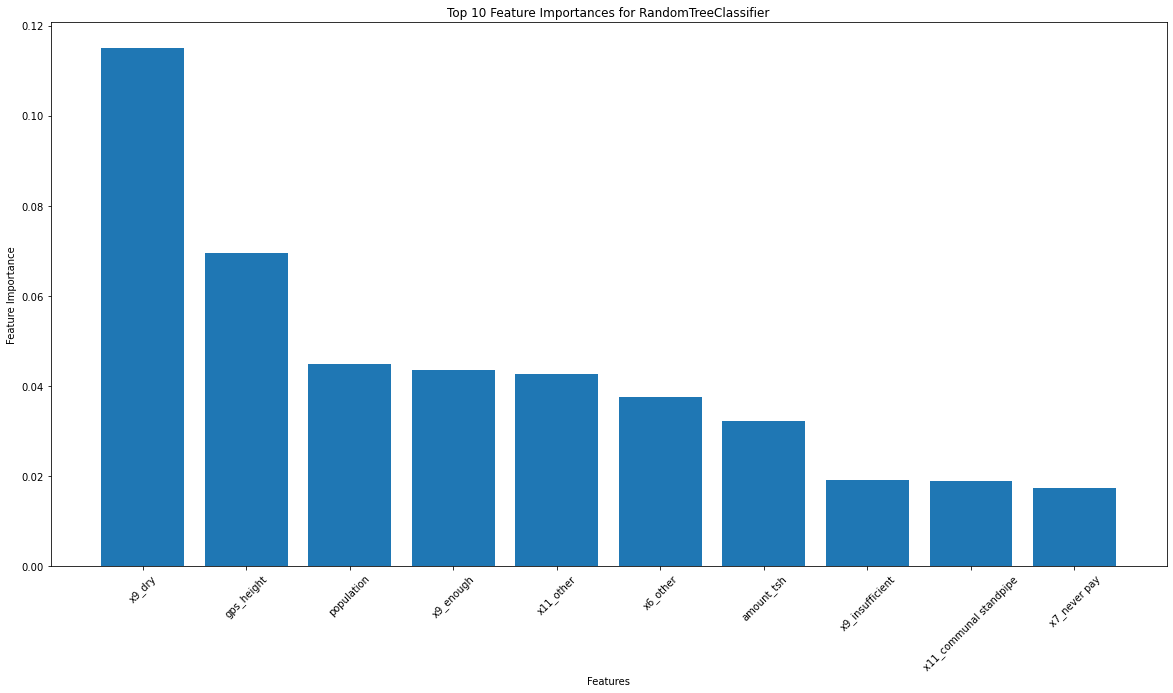

In [32]:
fig, ax = plt.subplots(figsize=(20,10))

features = [x[0] for x in forest_importances]
importances = [x[1] for x in forest_importances]
ax.bar(features, importances)

ax.tick_params(axis='x', labelrotation = 45)
ax.set_title('Top 10 Feature Importances for RandomTreeClassifier')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features');

## Second Model - Bagging Classifier

Our second model was a BaggingClassifier. This BaggingClassifier was an ensemble estimator with a DecisionTreeClassifier as the base estimator. The model bags the original dataset into random subsets, fits the base classifier on these subsets, and aggregates their individual predictions to form a final prediciton.

In [33]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=50, min_samples_leaf=1,min_samples_split=10)

bagging_dt_model = BaggingClassifier(base_estimator=dt, n_estimators=100, random_state=42)

bag_dt_pipe = Pipeline(steps = [('ct', CT),
                                ('baglogreg', bagging_dt_model )])

In [57]:
cross_val_score(bag_dt_pipe, X_train, y_train).mean()

0.8414716657910286

In [59]:
#dtc_gs = GridSearchCV(bag_dt_pipe, dtc_params, cv=5, verbose=1, n_jobs=-2)


#dtc_gs.fit(X_train, y_train)

#dtc_best = dtc_gs.best_estimator_
#dtc_gs.best_params_

In [60]:
#Results from BaggingClassifier grid search

#{'baglogreg__base_estimator': DecisionTreeClassifier(max_depth=50, min_samples_split=10),
 #'baglogreg__max_features': 0.7,
 #'baglogreg__max_samples': 1.0,
 #'baglogreg__n_estimators': 100}
    
#dtc_gs.best_score_
#0.8514029180695847

The GridSearchCV best score for the BaggingClassifier was 0.851, a slight improvement on our RandomForestClassifier's score. 

In [34]:
dt = DecisionTreeClassifier(max_depth=50, min_samples_split=10)

bagging_dt_model = BaggingClassifier(base_estimator=dt, n_estimators=100,
                                     max_features=0.7, max_samples=1.0,
                                     random_state=42)

bag_dt_pipe = Pipeline(steps = [('ct', CT),
                                ('baglogreg', bagging_dt_model )])

In [66]:
bag_dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'district_code',
                                                   'lga', 'management',
                                      

In [64]:
bag_dt_pipe.score(X_train, y_train)

0.9248917598573777

The accuracy on the train data and the cross valiation scores for this Bagging classifier were both greater than those of the Random Forest. However, we're interested in how the model performs on unseen data: our holdout validation set from the train-test split.

## Third Model - KNN Classifier

Our final model type was a KNeighborsClassifier. The model classifies a data point by searching for the k-nearest neighbors and checking their classifications. The class of the data point is determined by a vote of their neighbors; however, the 'weights' parameter in the classifer can be used to specify how this vote is carried out. In our model, the 'weights' parameter was set to 'distance', meaning points that were close to the query point had a greater influence on the vote than neighbors who were further away.

In [68]:
#pipeline for a knn classifier model
knn = KNeighborsClassifier(n_neighbors=12, leaf_size=2, metric='manhattan', p=2, weights='distance')

knn_model_pipe = Pipeline(steps = [('ct', CT),
                                   ('KN', knn )])
knn_model_pipe.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'district_code',
                                                   'lga', 'management',
                                      

In [69]:
#grid search for KNN
#grid = {'KN__n_neighbors':range(6, 10), 'KN__leaf_size':range(4), 'KN__metric':['minkowski', 'manhattan'], 'KN__weights':['uniform', 'distance'], 'KN__p':[2]}

#knn_gs = GridSearchCV(estimator=knn_model_pipe, param_grid=grid, cv=5, n_jobs=-1, verbose=3)
#knn_gs.fit(X_train, y_train)

In [70]:
#Results from KNN grid search

#knn_gs.best_params_
#{'KN__leaf_size': 1,
# 'KN__metric': 'manhattan',
# 'KN__n_neighbors': 9,
# 'KN__p': 2,
# 'KN__weights': 'distance'}

#knn_gs.best_score_
#0.829023569023569

#knn_gs.best_estimator_.score(X_test, y_test)

The grid search with cross validation for the KNN model yielded a score of 0.829. This accuracy is lower than those of our other two models.

## Evaluation of Models on Test Set

## Conclusion